<a href="https://colab.research.google.com/github/Zuhair0000/FYP-Research/blob/main/FYP_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os

# List all files in the Colab working directory
print(os.listdir("/content"))

['.config', '风力春季发电.xlsx', '风力秋季发电.xlsx', 'clean_solar_wind.pkl', '光伏冬季发电.xlsx', '风力冬季发电.xlsx', '风力夏季发电.xlsx', 'clean_solar_wind.csv', '光伏秋季发电.xlsx', '光伏春季发电.xlsx', '光伏夏季发电.xlsx', 'sample_data']


In [21]:
import glob
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

all_files = glob.glob("/content/*.xlsx")
print("All Excel files:", all_files)

# Separate solar and wind
solar_files = [f for f in all_files if "光伏" in f]
wind_files  = [f for f in all_files if "风力" in f]

print("Solar files:", solar_files)
print("Wind files:", wind_files)

All Excel files: ['/content/风力春季发电.xlsx', '/content/风力秋季发电.xlsx', '/content/光伏冬季发电.xlsx', '/content/风力冬季发电.xlsx', '/content/风力夏季发电.xlsx', '/content/光伏秋季发电.xlsx', '/content/光伏春季发电.xlsx', '/content/光伏夏季发电.xlsx']
Solar files: ['/content/光伏冬季发电.xlsx', '/content/光伏秋季发电.xlsx', '/content/光伏春季发电.xlsx', '/content/光伏夏季发电.xlsx']
Wind files: ['/content/风力春季发电.xlsx', '/content/风力秋季发电.xlsx', '/content/风力冬季发电.xlsx', '/content/风力夏季发电.xlsx']


In [22]:

# Load solar
solar_dfs = [pd.read_excel(f) for f in solar_files]
solar_data = pd.concat(solar_dfs, ignore_index=True)

# Load wind
wind_dfs = [pd.read_excel(f) for f in wind_files]
wind_data = pd.concat(wind_dfs, ignore_index=True)

print("Solar shape:", solar_data.shape)
print("Wind shape:", wind_data.shape)

Solar shape: (8753, 7)
Wind shape: (8752, 5)


In [23]:
print("Solar columns:", solar_data.columns)
print(solar_data.head())

print("\nWind columns:", wind_data.columns)
print(wind_data.head())

print("\nMissing values in Solar:\n", solar_data.isnull().sum())
print("\nMissing values in Wind:\n", wind_data.isnull().sum())

Solar columns: Index(['年份', '时间', '温度', '湿度', '地面辐射强度', '大气上层辐射强度', '光伏发电'], dtype='object')
                   年份  时间      温度     湿度  地面辐射强度  大气上层辐射强度  光伏发电
0 2019-12-01 00:00:00   1 -10.687  0.001     0.0       0.0   0.0
1 2019-12-01 01:00:00   2 -10.623  0.001     0.0       0.0   0.0
2 2019-12-01 02:00:00   3 -10.564  0.001     0.0       0.0   0.0
3 2019-12-01 03:00:00   4 -10.954  0.001     0.0       0.0   0.0
4 2019-12-01 04:00:00   5 -11.344  0.001     0.0       0.0   0.0

Wind columns: Index(['年份', '时间', '空气密度', '风速', '发电功率'], dtype='object')
                   年份  时间   空气密度     风速     发电功率
0 2019-03-01 00:00:00   1  1.282  0.955    0.020
1 2019-03-01 01:00:00   2  1.270  0.881    0.010
2 2019-03-01 02:00:00   3  1.260  1.627    1.825
3 2019-03-01 03:00:00   4  1.253  2.421   26.870
4 2019-03-01 04:00:00   5  1.249  3.450  165.285

Missing values in Solar:
 年份          0
时间          0
温度          0
湿度          0
地面辐射强度      0
大气上层辐射强度    0
光伏发电        0
dtype: int64

Missing val

In [24]:
# --- Solar ---
solar_data = solar_data.rename(columns={
    "年份": "DateTime",
    "时间": "Index",
    "温度": "Temperature",
    "湿度": "Humidity",
    "地面辐射强度": "Ground_Irradiance",
    "大气上层辐射强度": "Atmospheric_Irradiance",
    "光伏发电": "Solar_Power"
})

# --- Wind ---
wind_data = wind_data.rename(columns={
    "年份": "DateTime",
    "时间": "Index",
    "空气密度": "Air_Density",
    "风速": "Wind_Speed",
    "发电功率": "Wind_Power"
})

In [25]:
solar_data["DateTime"] = pd.to_datetime(solar_data["DateTime"])
wind_data["DateTime"]  = pd.to_datetime(wind_data["DateTime"])

# Sort by datetime
solar_data = solar_data.sort_values("DateTime")
wind_data  = wind_data.sort_values("DateTime")
solar_data


,DateTime,Index,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power
744,2019-01-01 08:00:00,745,-19.889,0.001,82.680,209.252,257.690
745,2019-01-01 09:00:00,746,-19.004,0.001,149.553,345.604,530.391
746,2019-01-01 10:00:00,747,-17.971,0.001,193.625,430.654,871.016
747,2019-01-01 11:00:00,748,-17.281,0.001,203.808,458.550,1087.304
748,2019-01-01 12:00:00,749,-16.738,0.001,185.193,427.391,1010.161
...,...,...,...,...,...,...,...
739,2019-12-31 19:00:00,740,-23.621,0.000,0.000,0.000,0.000
740,2019-12-31 20:00:00,741,-23.980,0.000,0.000,0.000,0.000
741,2019-12-31 21:00:00,742,-24.826,0.000,0.000,0.000,0.000
742,2019-12-31 22:00:00,743,-26.172,0.000,0.000,0.000,0.000


In [26]:
solar_data = solar_data.drop(columns=["Index"])
wind_data  = wind_data.drop(columns=["Index"])

In [27]:
print("Solar date range:", solar_data["DateTime"].min(), "→", solar_data["DateTime"].max())
print("Wind date range:", wind_data["DateTime"].min(), "→", wind_data["DateTime"].max())

print("\nSolar frequency check:")
print(solar_data["DateTime"].diff().value_counts().head())

print("\nWind frequency check:")
print(wind_data["DateTime"].diff().value_counts().head())

Solar date range: 2019-01-01 08:00:00 → 2019-12-31 23:00:00
Wind date range: 2019-01-01 08:00:00 → 2019-12-31 23:00:00

Solar frequency check:
DateTime
0 days 01:00:00    8751
0 days 00:00:00       1
Name: count, dtype: int64

Wind frequency check:
DateTime
0 days 01:00:00    8751
Name: count, dtype: int64


In [28]:
# Resample Solar
solar_data = solar_data.set_index("DateTime").resample("h").mean().interpolate()

# Resample Wind
wind_data = wind_data.set_index("DateTime").resample("h").mean().interpolate()

# Reset index back
solar_data = solar_data.reset_index()
wind_data  = wind_data.reset_index()

In [29]:
merged_data = pd.merge_asof(
    solar_data.sort_values("DateTime"),
    wind_data.sort_values("DateTime"),
    on="DateTime",
    direction="nearest"  # matches closest timestamp
)
merged_data

,DateTime,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power,Air_Density,Wind_Speed,Wind_Power
0,2019-01-01 08:00:00,-19.889,0.001,82.680,209.252,257.690,1.335,6.178,1203.800
1,2019-01-01 09:00:00,-19.004,0.001,149.553,345.604,530.391,1.337,6.534,1410.415
2,2019-01-01 10:00:00,-17.971,0.001,193.625,430.654,871.016,1.339,6.747,1547.633
3,2019-01-01 11:00:00,-17.281,0.001,203.808,458.550,1087.304,1.340,6.765,1556.072
4,2019-01-01 12:00:00,-16.738,0.001,185.193,427.391,1010.161,1.342,6.606,1456.741
...,...,...,...,...,...,...,...,...,...
8747,2019-12-31 19:00:00,-23.621,0.000,0.000,0.000,0.000,1.385,6.260,1254.654
8748,2019-12-31 20:00:00,-23.980,0.000,0.000,0.000,0.000,1.387,5.784,995.959
8749,2019-12-31 21:00:00,-24.826,0.000,0.000,0.000,0.000,1.388,4.955,614.468
8750,2019-12-31 22:00:00,-26.172,0.000,0.000,0.000,0.000,1.388,4.525,457.358


In [30]:
for lag in [1, 3, 6, 24]:  # 1h, 3h, 6h, 24h lags
    merged_data[f"Solar_Power_lag{lag}"] = merged_data["Solar_Power"].shift(lag)
    merged_data[f"Wind_Power_lag{lag}"] = merged_data["Wind_Power"].shift(lag)

In [31]:
merged_data["Solar_Power_roll6h"] = merged_data["Solar_Power"].rolling(window=6).mean()
merged_data["Wind_Power_roll6h"] = merged_data["Wind_Power"].rolling(window=6).mean()

In [32]:
merged_data["hour"] = merged_data["DateTime"].dt.hour
merged_data["dayofweek"] = merged_data["DateTime"].dt.dayofweek
merged_data["month"] = merged_data["DateTime"].dt.month

In [33]:
merged_data = merged_data.dropna().reset_index(drop=True)

In [34]:
train = merged_data[:7000].copy()
val = merged_data[7000:8000].copy()
test = merged_data[8000:].copy()

scaler = MinMaxScaler()
scaled_cols = ["Temperature", "Humidity", "Ground_Irradiance", "Atmospheric_Irradiance",
               "Solar_Power", "Air_Density", "Wind_Speed", "Wind_Power"]

scaler.fit(train[scaled_cols])

train[scaled_cols] = scaler.transform(train[scaled_cols])
val[scaled_cols] = scaler.transform(val[scaled_cols])
test[scaled_cols] = scaler.transform(test[scaled_cols])

In [35]:
merged_data

,DateTime,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power,Air_Density,Wind_Speed,Wind_Power,Solar_Power_lag1,...,Wind_Power_lag3,Solar_Power_lag6,Wind_Power_lag6,Solar_Power_lag24,Wind_Power_lag24,Solar_Power_roll6h,Wind_Power_roll6h,hour,dayofweek,month
0,2019-01-02 08:00:00,-19.250,0.001,106.671,210.916,1492.473,1.337,2.134,12.164,218.077,...,9.707,0.000,49.052,257.690,1203.800,285.091667,14.552000,8,2,1
1,2019-01-02 09:00:00,-17.086,0.001,215.461,347.367,3056.507,1.340,3.019,88.999,1492.473,...,11.803,0.000,28.576,530.391,1410.415,794.509500,24.622500,9,2,1
2,2019-01-02 10:00:00,-15.147,0.001,296.217,432.474,3492.641,1.343,4.137,335.753,3056.507,...,11.997,0.000,13.065,871.016,1547.633,1376.616333,78.403833,10,2,1
3,2019-01-02 11:00:00,-13.838,0.001,322.804,460.390,3499.852,1.345,4.821,562.194,3492.641,...,12.164,0.000,9.707,1087.304,1556.072,1959.925000,170.485000,11,2,1
4,2019-01-02 12:00:00,-13.104,0.001,295.867,429.221,3383.428,1.347,5.215,722.226,3499.852,...,88.999,0.000,11.803,1010.161,1456.741,2523.829667,288.888833,12,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8723,2019-12-31 19:00:00,-23.621,0.000,0.000,0.000,0.000,1.385,6.260,1254.654,0.000,...,1405.135,1409.988,1088.591,0.000,1629.479,173.893667,1264.816167,19,1,12
8724,2019-12-31 20:00:00,-23.980,0.000,0.000,0.000,0.000,1.387,5.784,995.959,0.000,...,1444.480,906.648,978.892,0.000,1374.040,22.785667,1267.660667,20,1,12
8725,2019-12-31 21:00:00,-24.826,0.000,0.000,0.000,0.000,1.388,4.955,614.468,0.000,...,1386.523,136.714,1119.213,0.000,1468.884,0.000000,1183.536500,21,1,12
8726,2019-12-31 22:00:00,-26.172,0.000,0.000,0.000,0.000,1.388,4.525,457.358,0.000,...,1254.654,0.000,1405.135,0.000,1482.002,0.000000,1025.573667,22,1,12


In [36]:
# Save as CSV
merged_data.to_csv("clean_solar_wind.csv", index=False)

# Save as Pickle (keeps data types, useful for reloading later)
merged_data.to_pickle("clean_solar_wind.pkl")

In [37]:
from google.colab import files
files.download("clean_solar_wind.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
from google.colab import output
!git config --global user.email "zuhairhassan52@gmail.com"
!git config --global user.name "Zuhair0000"

In [39]:
try:
  merged_data
  print("Using merged_data from environment. Rows:", len(merged_data))
except NameError:
  raise RuntimeError("No 'merged_data' ofund. Load your cleaned CSV first.")

Using merged_data from environment. Rows: 8728


In [40]:
h = 1

df = merged_data.copy().sort_values("DateTime").reset_index(drop=True)

df["Solar_target"] = df["Solar_Power"].shift(-h)
df["Wind_target"] = df["Wind_Power"].shift(-h)

df = df.iloc[:-h].reset_index(drop=True)

print("Data prepared — rows after shifting:", len(df))
print("Example columns:", df.columns.tolist())

Data prepared — rows after shifting: 8727
Example columns: ['DateTime', 'Temperature', 'Humidity', 'Ground_Irradiance', 'Atmospheric_Irradiance', 'Solar_Power', 'Air_Density', 'Wind_Speed', 'Wind_Power', 'Solar_Power_lag1', 'Wind_Power_lag1', 'Solar_Power_lag3', 'Wind_Power_lag3', 'Solar_Power_lag6', 'Wind_Power_lag6', 'Solar_Power_lag24', 'Wind_Power_lag24', 'Solar_Power_roll6h', 'Wind_Power_roll6h', 'hour', 'dayofweek', 'month', 'Solar_target', 'Wind_target']


In [43]:
feature_cols = [
    "Temperature", "Humidity", "Ground_Irradiance", "Atmospheric_Irradiance",
    "Air_Density", "Wind_Speed", "Solar_Power_lag1", "Solar_Power_lag24",
    "Wind_Power_lag1", "Wind_Power_lag24", "hour", "dayofweek", "month"
]

feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)

X = df[feature_cols].copy()
y_solar = df["Solar_target"].copy()
y_wind = df["Wind_target"].copy()

Using features: ['Temperature', 'Humidity', 'Ground_Irradiance', 'Atmospheric_Irradiance', 'Air_Density', 'Wind_Speed', 'Solar_Power_lag1', 'Solar_Power_lag24', 'Wind_Power_lag1', 'Wind_Power_lag24', 'hour', 'dayofweek', 'month']


In [44]:
# Cell 4: time-based split (70% train, 15% val, 15% test)
n = len(df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

X_train = X.iloc[:train_end].copy()
X_val   = X.iloc[train_end:val_end].copy()
X_test  = X.iloc[val_end:].copy()

y_train_s = y_solar.iloc[:train_end].copy()
y_val_s   = y_solar.iloc[train_end:val_end].copy()
y_test_s  = y_solar.iloc[val_end:].copy()

print("Sizes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

Sizes -> train: (6108, 13) val: (1309, 13) test: (1310, 13)


In [75]:
# ✅ Cell 5: Evaluation utilities + Persistence baseline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- SMAPE function ---
def smape(y_true, y_pred):
    """ Symmetric Mean Absolute Percentage Error (0–200%). """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# --- General evaluation function ---
def evaluate_metrics(y_true, y_pred):
    """Compute RMSE, MAE, SMAPE, R² for regression forecasts."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"RMSE": rmse, "MAE": mae, "SMAPE(%)": smape_val, "R2": r2}

# --- Persistence baseline (1-hour ahead) ---
# Forecast = Solar_Power(t) for predicting Solar_Power(t+1)
if "Solar_Power" in X_test.columns:
    y_pred_persist = X_test["Solar_Power"]
else:
    y_pred_persist = df["Solar_Power"].iloc[val_end:val_end+len(X_test)].reset_index(drop=True)

# Evaluate persistence
persist_scores = evaluate_metrics(y_test_s.values, y_pred_persist.values)
print("Persistence baseline (Solar) ->", persist_scores)

Persistence baseline (Solar) -> {'RMSE': np.float64(398.81572229629853), 'MAE': 184.7564740458015, 'SMAPE(%)': np.float64(35.64301535577778), 'R2': 0.8194389049293163}


In [77]:
# Cell 6: Linear Regression (pipeline with StandardScaler)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import joblib

# Define pipeline: scaling + model
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),     # standardize features
    ("lr", LinearRegression())        # linear regression model
])

# Fit on training data
lr_pipeline.fit(X_train, y_train_s)

# Predict on test
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate using updated SMAPE-based metrics
lr_scores = evaluate_metrics(y_test_s.values, y_pred_lr)
print("Linear Regression ->", lr_scores)

# Save trained model
joblib.dump(lr_pipeline, "lr_pipeline_solar.joblib")

Linear Regression -> {'RMSE': np.float64(570.6679569543222), 'MAE': 407.3402723682594, 'SMAPE(%)': np.float64(150.150823290955), 'R2': 0.6303024152949392}


['lr_pipeline_solar.joblib']

In [79]:
# Cell 7: Random Forest with GridSearchCV (time-series CV)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib

# Define time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # respects temporal ordering

# Base RF model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 3]
}

# GridSearch with time-series CV
gsearch = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",  # optimize RMSE
    n_jobs=-1,
    verbose=1
)

# Fit on training set only
gsearch.fit(X_train, y_train_s)

print("Best RF params:", gsearch.best_params_)
best_rf = gsearch.best_estimator_

# Evaluate best RF on test
y_pred_rf = best_rf.predict(X_test)
rf_scores = evaluate_metrics(y_test_s.values, y_pred_rf)
print("Random Forest ->", rf_scores)

# Save best RF
joblib.dump(best_rf, "best_rf_solar.joblib")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 200}
Random Forest -> {'RMSE': np.float64(432.0855920379183), 'MAE': 208.69593886535145, 'SMAPE(%)': np.float64(113.22106954118509), 'R2': 0.7880569362520835}


['best_rf_solar.joblib']

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def smape(y_true, y_pred):
    """ Symmetric Mean Absolute Percentage Error (0–200%). """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

def walk_forward_eval(model, X, y, initial, step):
    """
    Walk-forward validation for time-series forecasting.
    Expands training window step by step and evaluates predictions.

    Parameters:
        model   : sklearn-like estimator
        X, y    : full dataset (features and target)
        initial : size of initial training set
        step    : how many samples to add in each iteration
    """
    preds, actuals = [], []

    for i in range(initial, len(X), step):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test   = X[i:i+step], y[i:i+step]

        if len(X_test) == 0:  # no more test points
            break

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        preds.extend(y_pred)
        actuals.extend(y_test)

    # Convert to arrays
    preds = np.array(preds)
    actuals = np.array(actuals)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mae = mean_absolute_error(actuals, preds)
    smape_val = smape(actuals, preds)
    r2 = r2_score(actuals, preds)

    return {"RMSE": rmse, "MAE": mae, "SMAPE(%)": smape_val, "R2": r2}

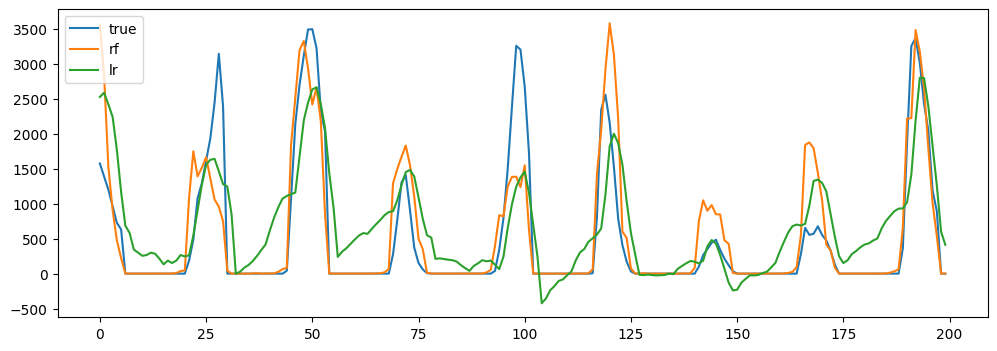

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(y_test_s.values[:200], label="true")
plt.plot(y_pred_rf[:200], label="rf")
plt.plot(y_pred_lr[:200], label="lr")
plt.legend()
plt.show()

In [82]:
sorted(zip(feature_cols, best_rf.feature_importances_), key=lambda x: x[1], reverse=True)

[('Ground_Irradiance', np.float64(0.5965764581098184)),
 ('Solar_Power_lag1', np.float64(0.1617507979057815)),
 ('hour', np.float64(0.12387720316893217)),
 ('Solar_Power_lag24', np.float64(0.05154958749418772)),
 ('Atmospheric_Irradiance', np.float64(0.020821122850727448)),
 ('Temperature', np.float64(0.017796413432499148)),
 ('Air_Density', np.float64(0.006743412398669261)),
 ('Wind_Power_lag24', np.float64(0.004969530415703237)),
 ('Wind_Speed', np.float64(0.0040295129322397046)),
 ('Wind_Power_lag1', np.float64(0.0037185043508993175)),
 ('Humidity', np.float64(0.0028258660825086017)),
 ('dayofweek', np.float64(0.0026890090811491473)),
 ('month', np.float64(0.0026525817768844073))]

In [83]:
# Cell: XGBoost Implementation
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid (a small one to start)
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

grid_xgb = GridSearchCV(
    xgb_model,
    param_grid=xgb_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train_s)

best_xgb = grid_xgb.best_estimator_
print("Best XGB params:", grid_xgb.best_params_)

# Evaluate on test set
xgb_pred = best_xgb.predict(X_test)
xgb_metrics = evaluate_metrics(y_test_s, xgb_pred)
print("XGBoost ->", xgb_metrics)

# Save model
joblib.dump(best_xgb, "best_xgb_solar.joblib")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBoost -> {'RMSE': np.float64(418.1856279973868), 'MAE': 247.07919107484435, 'SMAPE(%)': np.float64(148.48930042459125), 'R2': 0.8014737933510269}


['best_xgb_solar.joblib']

In [84]:
# Walk-forward evaluation for XGB
walk_xgb = walk_forward_eval(
    XGBRegressor(**grid_xgb.best_params_, objective="reg:squarederror", random_state=42),
    pd.concat([X_train, X_val, X_test]).reset_index(drop=True),
    pd.concat([y_train_s, y_val_s, y_test_s]).reset_index(drop=True),
    initial=int(0.5 * len(X_train)),  # size of first training window
    step=int(len(X_test) / 5) if len(X_test) >= 5 else 1  # expand window gradually
)

print("Walk-forward metrics for XGB:", walk_xgb)

Walk-forward metrics for XGB: {'RMSE': np.float64(367.8880170888832), 'MAE': 218.64487852814244, 'SMAPE(%)': np.float64(117.10509690702209), 'R2': 0.9134673156591961}


In [85]:
# Collect results into a DataFrame
results = pd.DataFrame([
    {"model": "Persistence", **persist_scores},
    {"model": "LinearRegression", **lr_scores},
    {"model": "RandomForest", **rf_scores},
    {"model": "XGBoost", **xgb_metrics}   # add XGBoost results
])

results

,model,RMSE,MAE,SMAPE(%),R2
0,Persistence,398.815722,184.756474,35.643015,0.819439
1,LinearRegression,570.667957,407.340272,150.150823,0.630302
2,RandomForest,432.085592,208.695939,113.221070,0.788057
3,XGBoost,418.185628,247.079191,148.489300,0.801474


In [88]:
# ---- Walk-forward results collection ----
results_walk = pd.DataFrame([
    {"model": "RandomForest", **walk_rf},
    {"model": "XGBoost", **walk_xgb}
    # Later you can also add walk-forward for LinearRegression or even Persistence if you implement it
])

# Display
print("Walk-forward results:")
results_walk

Walk-forward results:


,model,RMSE,MAE,MAPE(%),R2,SMAPE(%)
0,RandomForest,361.051421,195.606144,171.692266,0.904561,NaN
1,XGBoost,367.888017,218.644879,NaN,0.913467,117.105097


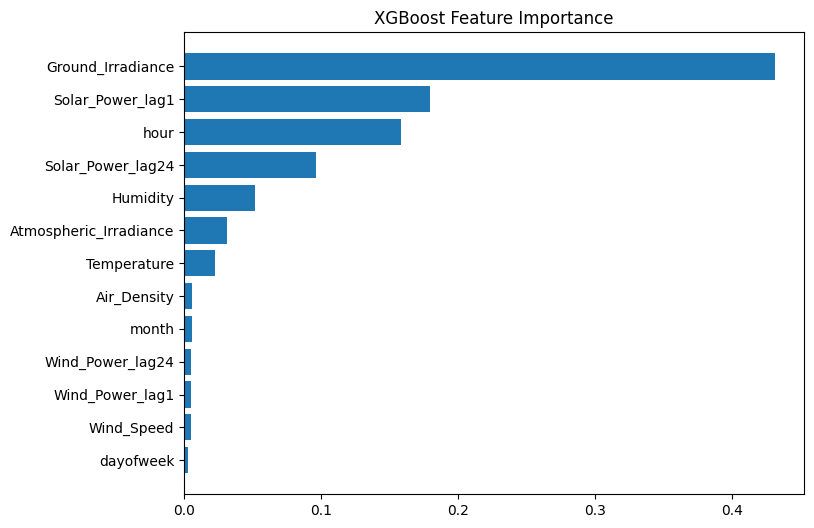

In [90]:
import matplotlib.pyplot as plt

xgb_importances = best_xgb.feature_importances_
feat_imp = pd.DataFrame({"Feature": X_train.columns, "Importance": xgb_importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()

In [89]:
# Merge static vs walk-forward into one summary
merged_results = results.set_index("model").join(
    results_walk.set_index("model"),
    lsuffix="_static", rsuffix="_walk"
)

merged_results

,RMSE_static,MAE_static,SMAPE(%)_static,R2_static,RMSE_walk,MAE_walk,MAPE(%),R2_walk,SMAPE(%)_walk
model,,,,,,,,,
Persistence,398.815722,184.756474,35.643015,0.819439,NaN,NaN,NaN,NaN,NaN
LinearRegression,570.667957,407.340272,150.150823,0.630302,NaN,NaN,NaN,NaN,NaN
RandomForest,432.085592,208.695939,113.221070,0.788057,361.051421,195.606144,171.692266,0.904561,NaN
XGBoost,418.185628,247.079191,148.489300,0.801474,367.888017,218.644879,NaN,0.913467,117.105097
